Canonical Correlations:  [0.34946171 0.02685025 0.00232981]


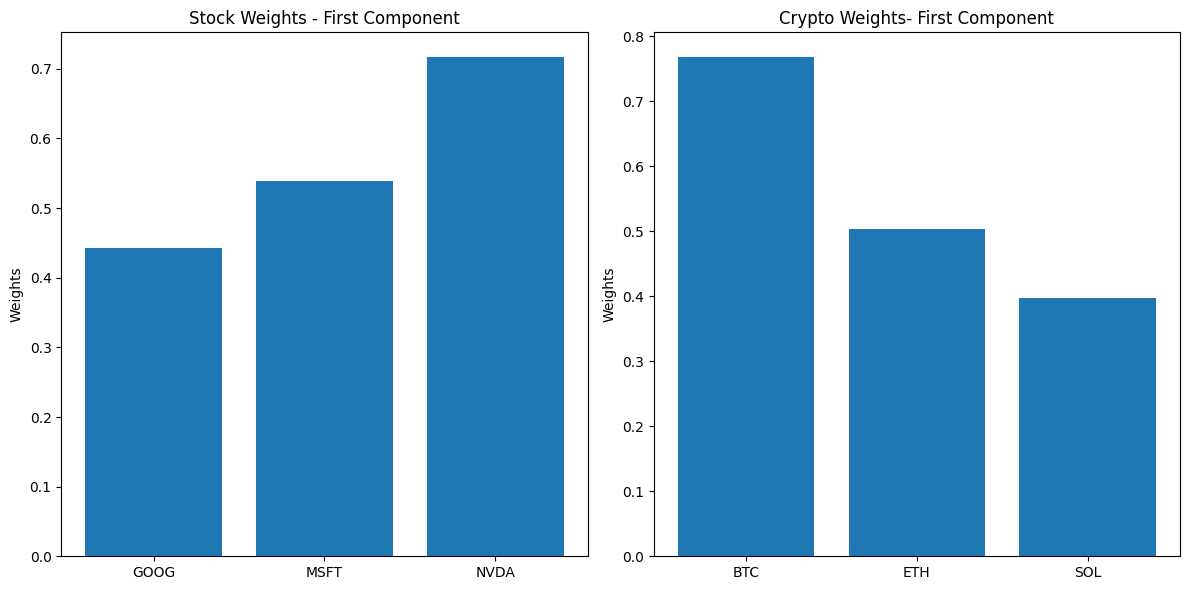

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA

stocks = pd.read_csv('stocks.csv', parse_dates=['Date'], index_col='Date')
crypto = pd.read_csv('crypto.csv', parse_dates=['Date'], index_col='Date')


data = pd.concat([stocks, crypto], axis=1, join='inner')

returns = data.pct_change().dropna()

stock_returns = returns[["GOOG", "MSFT", "NVDA"]]
crypto_returns = returns[["BTC-USD", "ETH-USD", "SOL-USD"]]

scaler_stock = StandardScaler()
scaler_crypto = StandardScaler()

X = scaler_stock.fit_transform(stock_returns)
Y = scaler_stock.fit_transform(crypto_returns)

cca = CCA(n_components = 3)
cca.fit(X, Y)

X_c, Y_c = cca.transform(X, Y)

correlations = [np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(3)]
print("Canonical Correlations: ", np.array(correlations))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Stock Weights - First Component')
plt.bar(['GOOG', 'MSFT', 'NVDA'], cca.x_weights_[:, 0])
plt.ylabel('Weights')

plt.subplot(1, 2, 2)
plt.title('Crypto Weights- First Component')
plt.bar(['BTC', 'ETH', 'SOL'], cca.y_weights_[:, 0])
plt.ylabel('Weights')

plt.tight_layout()
plt.show()

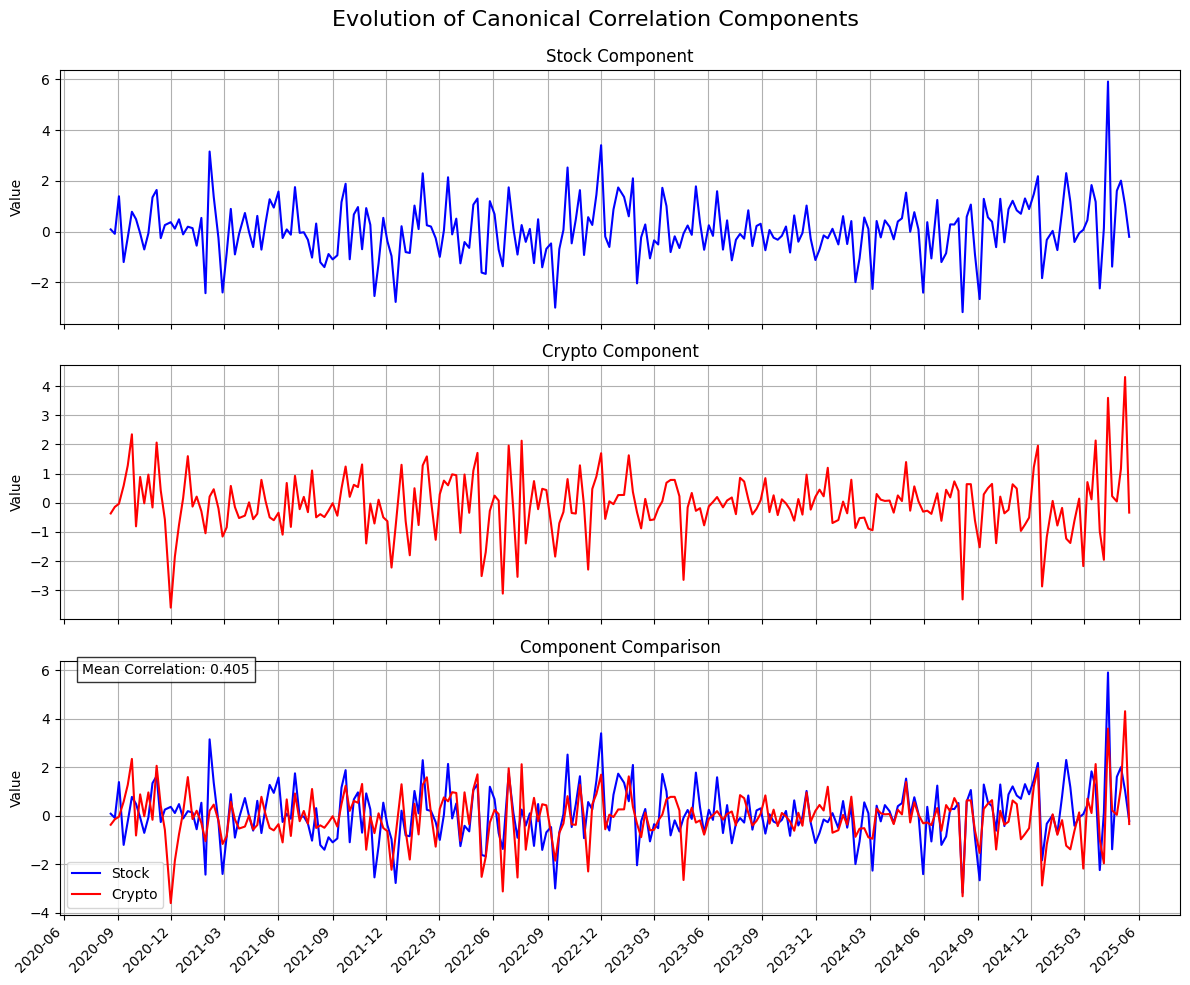

Last Correlation: 0.5190
Mean Correlation: 0.4055


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

# Carica i dati
stocks = pd.read_csv('stocks.csv', parse_dates=['Date'], index_col='Date')
crypto = pd.read_csv('crypto.csv', parse_dates=['Date'], index_col='Date')
data = pd.concat([stocks, crypto], axis=1, join='inner')
returns = data.pct_change().dropna()

# Impostazioni
window_size = 90  # Finestra mobile di 3 mesi
step = 5  # Aggiorniamo ogni 5 giorni

# Liste per salvare i dati
dates = []
stock_vals = []
crypto_vals = []
correlations = []

# Calcola tutte le componenti
for i in range(window_size, len(returns), step):
    current_data = returns.iloc[i-window_size:i]
    
    # Separa stock e crypto
    stock_returns = current_data[['GOOG', 'MSFT', 'NVDA']]
    crypto_returns = current_data[['BTC-USD', 'ETH-USD', 'SOL-USD']]
    
    # Standardizza
    scaler_stock = StandardScaler()
    scaler_crypto = StandardScaler()
    X = scaler_stock.fit_transform(stock_returns)
    Y = scaler_crypto.fit_transform(crypto_returns)
    
    # Calcola CCA
    cca = CCA(n_components=1)
    cca.fit(X, Y)
    X_c, Y_c = cca.transform(X, Y)
    
    # Calcola correlazione
    corr = np.corrcoef(X_c.squeeze(), Y_c.squeeze())[0, 1]
    
    # Salva i valori
    dates.append(returns.index[i])
    stock_vals.append(X_c[-1][0])
    crypto_vals.append(Y_c[-1][0])
    correlations.append(corr)

# Crea il grafico finale
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
fig.suptitle('Evolution of Canonical Correlation Components', fontsize=16)

# Grafico Stock
ax1.plot(dates, stock_vals, 'b-')
ax1.set_title('Stock Component')
ax1.set_ylabel('Value')
ax1.grid(True)

# Grafico Crypto
ax2.plot(dates, crypto_vals, 'r-')
ax2.set_title('Crypto Component')
ax2.set_ylabel('Value')
ax2.grid(True)

# Grafico combinato
ax3.plot(dates, stock_vals, 'b-', label='Stock')
ax3.plot(dates, crypto_vals, 'r-', label='Crypto')
ax3.set_title('Component Comparison')
ax3.set_ylabel('Value')
ax3.legend()
ax3.grid(True)

# Aggiungi correlazione media
mean_corr = np.mean(correlations)
ax3.text(0.02, 0.95, f'Mean Correlation: {mean_corr:.3f}', 
         transform=ax3.transAxes, bbox=dict(facecolor='white', alpha=0.8))

# Formattazione date
date_format = DateFormatter("%Y-%m")
for ax in [ax1, ax2, ax3]:
    ax.xaxis.set_major_formatter(date_format)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

# Stampa correlazione finale
print(f"Last Correlation: {correlations[-1]:.4f}")
print(f"Mean Correlation: {np.mean(correlations):.4f}")